In [1]:
#  -------------------------------------------------------------------------------------------
#  Copyright (c) Microsoft Corporation. All rights reserved.
#  Licensed under the MIT License (MIT). See LICENSE in the repo root for license information.
#  -------------------------------------------------------------------------------------------

# Phrase grounding

This notebook demonstrates the usage of the BioViL image and text models in a multi-modal phrase grounding setting.
Given a chest X-ray and a radiology text phrase, the joint model grounds the phrase in the image, i.e., highlights the regions of the image that share features similar to the phrase.

Please refer to the ECCV'22 manuscript for further details:

> Boecking, B., Usuyama, N., Bannur, S., Castro, D., Schwaighofer, A., Hyland, S., Wetscherek, M., Naumann, T., Nori, A., Alvarez-Valle, J., Poon, H., & Oktay, O. (2022). *Making the Most of Text Semantics to Improve Biomedical Vision–Language Processing* ([preprint](https://arxiv.org/abs/2204.09817))

The notebook can also be run on Binder without the need of any coding or local installation:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/microsoft/hi-ml/HEAD?labpath=hi-ml-multimodal%2Fnotebooks%2Fphrase_grounding.ipynb)

This demo is solely for research evaluation purposes, not intended to be a medical product or clinical use.

## Setup

Let's first install the `hi-ml-multimodal` Python package, which will allow us to import the `health_multimodal` Python module.

In [2]:
pip_source = "hi-ml-multimodal"

In [3]:
%pip install --quiet {pip_source}

Note: you may need to restart the kernel to use updated packages.


In [4]:
from pathlib import Path

import torch

from health_multimodal.text import get_cxr_bert_inference
from health_multimodal.image import get_biovil_resnet_inference
from health_multimodal.vlp import ImageTextInferenceEngine
from health_multimodal.common.visualization import plot_phrase_grounding_similarity_map

## Load multimodal model

Load the text and image models from [Hugging Face 🤗](https://aka.ms/biovil-models) and instantiate the inference engines:

In [5]:
text_inference = get_cxr_bert_inference()
image_inference = get_biovil_resnet_inference()

Using downloaded and verified file: /tmp/biovil_image_resnet50_proj_size_128.pt


/opt/conda/envs/biovil/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Instantiate the joint inference engine:

In [6]:
image_text_inference = ImageTextInferenceEngine(
    image_inference_engine=image_inference,
    text_inference_engine=text_inference,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_text_inference.to(device)

## Helper visualization functions

In [12]:
def plot_phrase_grounding(image_path: Path, text_prompt: str) -> None:
    similarity_map = image_text_inference.get_similarity_map_from_raw_data(
        image_path=image_path,
        query_text=text_prompt,
        interpolation="bilinear",
    )

    plot_phrase_grounding_similarity_map(
        image_path=image_path,
        similarity_map=similarity_map,
    )

def plot_phrase_grounding_from_url(image_url: str, text_prompt: str) -> None:
    # image_path = Path("./", "downloaded_chest_xray.jpg")
    # !curl -s -L -o {image_path} {image_url}
    image_path = Path("./", "view1_frontal.jpg")
    plot_phrase_grounding(image_path, text_prompt)

## Inference

We will run inference on a chest X-ray from [Radiopaedia](https://radiopaedia.org/), but any other chest X-ray image in DICOM or JPEG format can be used for research purposes.

In [13]:
# text_prompt = "Pneumonia in the right lung"
text_prompt = "Support Devices"
image_url = "https://prod-images-static.radiopaedia.org/images/1371188/0a1f5edc85aa58d5780928cb39b08659c1fc4d6d7c7dce2f8db1d63c7c737234_gallery.jpeg"

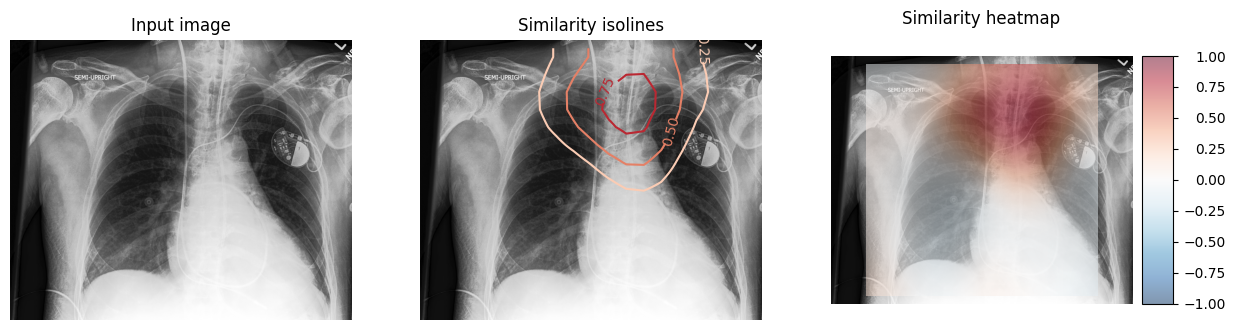

In [14]:
plot_phrase_grounding_from_url(image_url, text_prompt)

In [12]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import os
import json

from health_multimodal.text import get_cxr_bert_inference
from health_multimodal.image import get_biovil_resnet_inference
from health_multimodal.vlp import ImageTextInferenceEngine

# import encoding from cheXlocalize/heatmap_to_segmentation.py
from utils import encode_segmentation


def seg_one_sample(model, image_path, text_prompts, thres):
    """ Returns a dictionary of segmentation results for a single sample (key: disease, val: segmentation map). """
    sample = {}
    for text_prompt in text_prompts:
        # Get segmentation map
        similarity_map = model.get_similarity_map_from_raw_data(
            image_path=image_path,
            query_text=text_prompt,
            interpolation="bilinear",
        )

        # Remove nan values
        np.nan_to_num(similarity_map, copy=False)

        # Min-max scaling and thresholding
        similarity_map = (similarity_map - similarity_map.min()) / (similarity_map.max() - similarity_map.min())
        similarity_map = np.array(similarity_map > thres, dtype="int")

        # Apply encoding from cheXlocalize/heatmap_to_segmentation.py
        encoded_mask = encode_segmentation(similarity_map)
        sample[text_prompt] = encoded_mask

    return sample


def process_name(x):
    """ Clean up string from folder path to sample name format that matches the csv file. """
    x = x.replace("valid/", "")
    x = x.replace(".jpg", "")
    x = x.replace("/", "_")
    return x


def segmentation(img_folder_path, img_paths, text_prompts, thres=0.6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create biovil model
    text_inference = get_cxr_bert_inference()
    image_inference = get_biovil_resnet_inference()
    image_text_inference = ImageTextInferenceEngine(
        image_inference_engine=image_inference,
        text_inference_engine=text_inference,
    )
    image_text_inference.to(device)

    # Segmentation
    result = {}
    for i, img_path in enumerate(img_paths):
        sample_name = process_name(img_path)
        img_path = Path(img_folder_path, img_path)
        sample = seg_one_sample(image_text_inference, img_path, text_prompts, thres)
        result[sample_name] = sample
        if i % 100 == 0:
            print("Processed {} samples".format(i))
    
    return result



if __name__ == "__main__":
    img_folder_path = "/home/ec2-user/CHEXLOCALIZE/CheXpert/" # path to CheXpert test/val_labels.csv
    csv_path = "val_labels.csv"
    out_path = "./biovil_segmentations.json" # path to save segmentation results
    
    # Only look at view1_frontal images
    df = pd.read_csv(img_folder_path + csv_path)
    img_paths = df["Path"]
    img_paths = img_paths[img_paths.str.contains("view1_frontal")]
    img_paths = img_paths.to_list()
    img_paths = [x.replace("CheXpert-v1.0/", "") for x in img_paths]

    text_prompts = ["Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion", \
                    "Airspace Opacity", "Edema", "Consolidation", "Atelectasis", "Pneumothorax", \
                    "Pleural Effusion", "Support Devices"]
    result = segmentation(img_folder_path, img_paths, text_prompts, thres=0.6)

    # Save to json
    Path(os.path.dirname(out_path)).mkdir(exist_ok=True, parents=True)
    with open(out_path, 'w') as f:
        json.dump(result, f)


if __name__ == "__main__":
    pass

Using downloaded and verified file: /tmp/biovil_image_resnet50_proj_size_128.pt
/home/ec2-user/CHEXLOCALIZE/CheXpert/valid/patient64541/study1/view1_frontal.jpg patient64541_study1_view1_frontal
Processed 0 samples
/home/ec2-user/CHEXLOCALIZE/CheXpert/valid/patient64542/study1/view1_frontal.jpg patient64542_study1_view1_frontal
/home/ec2-user/CHEXLOCALIZE/CheXpert/valid/patient64543/study1/view1_frontal.jpg patient64543_study1_view1_frontal
/home/ec2-user/CHEXLOCALIZE/CheXpert/valid/patient64544/study1/view1_frontal.jpg patient64544_study1_view1_frontal
/home/ec2-user/CHEXLOCALIZE/CheXpert/valid/patient64545/study1/view1_frontal.jpg patient64545_study1_view1_frontal
/home/ec2-user/CHEXLOCALIZE/CheXpert/valid/patient64546/study1/view1_frontal.jpg patient64546_study1_view1_frontal
/home/ec2-user/CHEXLOCALIZE/CheXpert/valid/patient64547/study1/view1_frontal.jpg patient64547_study1_view1_frontal
/home/ec2-user/CHEXLOCALIZE/CheXpert/valid/patient64548/study1/view1_frontal.jpg patient64548_s